# CFO Correction Network

This notebooks contains two network architectures to **learn to correct Carrier Frequency Offset (CFO)**, given preamble and preamble convolved data.

* **First Approach**: Feedforward network
    * Pros: Faster inference
    * Cons: Fixed Preabmle Length
* **Second Approach**: Recurrent Neural Network network
    * Pros: variable preamble length
    * Cons: Slower

## Environment Setup

### Required packages
* Tensorflow
* Keras
* Commpy
* Pydot
*  `graphviz` for visualization. `sudo apt-get install graphviz`

In [1]:
# Import packages from other direction. Itis necessary if the project is structured as:
# my_project
# ├── notebooks
# │   └── current_notebook.ipynb
# ├── local_python_package
# │   ├── __init__.py
# │   ├── models.py
# ├── README.md
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import multiprocessing as mp
import numpy as np
import tensorflow as tf
from radioml.dataset import RadioData
from sklearn.metrics import mean_squared_error

# For visualization
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

## Define Parameters for this experiment

In [3]:
DATA_LEN = 200
PREAMBLE_LEN = 40
CHANNEL_LEN = 1

SNR_TRAIN = 20.0
OMEGA_TRAIN = 1/50

## Build a  data generator



In [4]:
def cfo_data_genenerator(radio, omega, snr_dB, batch_size, seed=None, num_cpus=4):
    """A generator function returns an `Iterator` object that 
    generates (inputs, labels) until it raises a `StopIteration` exception, 
    
    In this example, this generator generates data for CFO Correction network,
    which takes:
    
        Input:  [preamble, preamble_convolved]
        Output :[cfo_corrected_preamble]
        
    Arguments:
    ----------
        omega (float): angular frequency (in radian, e.g. 1/50, 1/100)
        snr_dB(float): signal-to-noise ratio in Decibel
        batch_size(int): number of samples per training/eval step
        seed  (int):
        num_cpus (int): number of cpu cores for generating data in parallel.
    
    Returns:
    --------
        `Iterator` object that yields 
            ([premables, preambles_conv], cfo_corrected_preamble)
            
    Example:
    --------
        >> train_set = cfo_data_generator(omega=1/50, snr_dB=15.0, batch_size=128)        
        >> for i in range(steps_per_epoch):
                inputs, labels = next(train_set)
                # training here      
    """
    pool = mp.Pool(num_cpus)
    try:
        np.random.seed(seed)
        while True:
            batch = pool.starmap(radio.generate_packet, 
                                [(omega, snr_dB) for i in range(batch_size)])
            np.random.seed()
            # In order to train CFO Correction Network, we only need access to 
            # cfo_corrected_preamble (not omega) as labels, preambles and 
            # preambles convolved data as inputs.
            original_packets, omegas, modulated_packets, \
            convolved_packets, rotated, corrupted_packets = zip(*batch)
            
            # Process Inputs
            # Obtain the preamble and preamble conv
            preamble_complex = np.array(modulated_packets)[:, :radio.preamble_len]
            preamble_conv_complex = np.array(corrupted_packets)[:, :radio.preamble_len]
            
            preambles     = radio._encode_complex(preamble_complex)
            preamble_conv = radio._encode_complex(preamble_conv_complex)

            # Process Labels   
            omegas = np.expand_dims(np.array(omegas), 1)
            # For example, batch_size = 2, preamble_len = 3, time_steps_matrix is
            # [[0, 1, 2],
            #  [0, 1, 2]]
            time_steps_matrix =  np.tile(np.arange(radio.preamble_len),(batch_size, 1))
        
            cfo_corrected_complex = preamble_conv_complex * np.exp(-1j * omegas * time_steps_matrix)
            
            # Encode complex to 2D
            cfo_corrected_preambles =radio._encode_complex(cfo_corrected_complex)
            
            yield [preambles, preamble_conv], cfo_corrected_preambles
 
    except Exception as e:
        pool.close()
        print(e)
        raise e

## Define training_set, validation_set

In [5]:
# Define Radio
radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=PREAMBLE_LEN, 
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')

training_generator   = cfo_data_genenerator(radio, OMEGA_TRAIN, SNR_TRAIN, batch_size=128, num_cpus=8)
validation_generator = cfo_data_genenerator(radio, OMEGA_TRAIN, SNR_TRAIN, batch_size=128, seed=2018)

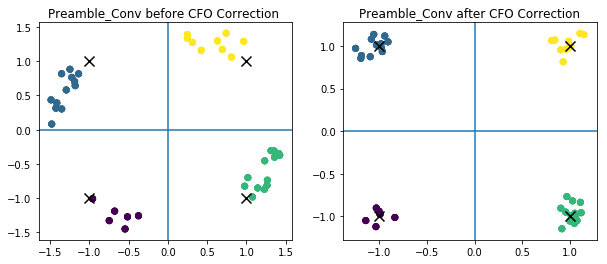

In [6]:
# Visualize a few examples
examples = next(cfo_data_genenerator(radio, OMEGA_TRAIN, SNR_TRAIN, batch_size=4, num_cpus=8))
[preambles, preambles_conv], cfo_corrected = examples
symbols, groundtruths = np.unique(preambles.view(np.complex),return_inverse=True)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(preambles_conv[...,0].flatten(),preambles_conv[...,1].flatten(), c=groundtruths)
ax1.scatter(np.real(symbols), np.imag(symbols), marker='x', s=100, color='black')
ax1.axhline()
_ = ax1.axvline()
ax1.set_title("Preamble_Conv before CFO Correction ")

ax2.scatter(cfo_corrected[...,0].flatten(),cfo_corrected[...,1].flatten(), c=groundtruths)
ax2.scatter(np.real(symbols), np.imag(symbols), marker='x', s=100, color='black')
ax2.axhline()
_ = ax2.axvline()
_ = ax2.set_title("Preamble_Conv after CFO Correction")

## First Approach: Feedforward Network

In [7]:
tf.keras.backend.clear_session()

def cfo_network(preamble, preamble_conv, scope='CFONet'):
    """Build CFO Correct Network (or Graph)
    
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
        
    Return:
        cfo_estimate: tf.Tensor float32 - [batch_size, 1]
        
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=1)
        inputs = tf.keras.layers.Flatten(name='Flatten')(inputs)
        x = tf.keras.layers.Dense(100, 'selu', name=scope+"_dense_1")(inputs)
        x = tf.keras.layers.Dense(100, 'selu', name=scope+"_dense_2")(x)
        x = tf.keras.layers.Dense(100, 'selu', name=scope+"_dense_3")(x)
    cfo_est = tf.keras.layers.Dense(1, 'linear',name='CFOEstimate')(x)
    return cfo_est

def cfo_correction_func(kwargs):
    """Rotate packets given an omega estimate 
    
    Arguments:
        omega_estimate: tf.Tensor float32 - [batch, 1]
        packets:        tf.Tensor float32 - [batch, (preamble_len + data_len), 2] 
        
    Return:
        rotated_packets: tf.Tensor float32 - [batch, (preamble_len + data_len), 2] 
    """ 
    # Because of Lambda Layer, we need to pass arguments as Kwargs
    omega_estimate, packets = kwargs[0], kwargs[1]

    # Build rotation matrix
    with tf.name_scope('rotation_matrix'):
        packet_len      = tf.cast(tf.shape(packets)[1], tf.float32) # preamble_len + data_len
        rotation_matrix = tf.exp(tf.complex(0.0, - 1.0 * omega_estimate * tf.range(packet_len)))

    # CFO Correction 
    with tf.name_scope('cfo_correction'):
        rotated_packets = tf.complex(packets[..., 0], packets[...,1]) * rotation_matrix

    # Encode complex packets into 2D array
    corrected_preambe = tf.stack([tf.real(rotated_packets),
                                  tf.imag(rotated_packets)], 
                                  axis=-1)
    
    return corrected_preambe

## Build CFO Correction Net

Number of training parameters: 36401


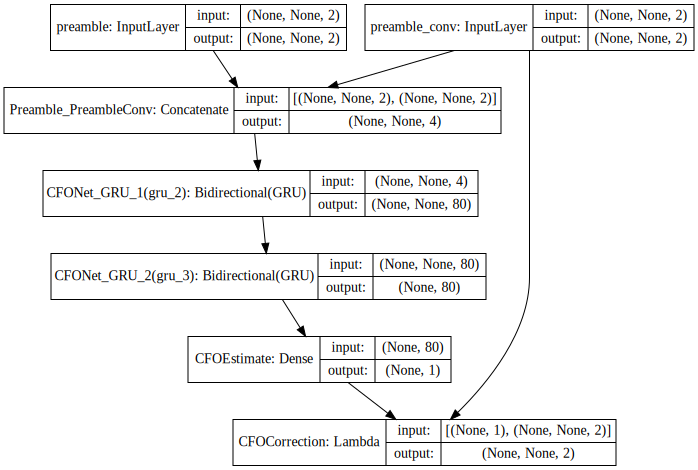

In [8]:
# Think of keras.Input as tf.placeholder
preamble       = tf.keras.layers.Input(shape=(PREAMBLE_LEN, 2), name='Preamble')
preamble_conv  = tf.keras.layers.Input(shape=(PREAMBLE_LEN, 2), name='PreambleConvolved')

# Build tensorflow graph
cfo_estimate           = cfo_network(preamble, preamble_conv)
cfo_corrected_preamble = tf.keras.layers.Lambda(cfo_correction_func,
                                                name='CFOCorrection')([cfo_estimate, preamble_conv])

feed_forward_model = tf.keras.Model(inputs=[preamble, preamble_conv], 
                                    outputs=cfo_corrected_preamble)

print("Number of training parameters: %d" % feed_forward_model.count_params())
tf.keras.utils.plot_model(feed_forward_model, "cfo_nn_model.svg", show_shapes=True, show_layer_names=True)
SVG("model.svg")

## Training Feedforward model

In [9]:
feed_forward_model.compile('adam','mse')

# Load pretrained-weights from cheating with omegas
feed_forward_model.load_weights('../models/cfo_nn.hdf5')  

In [10]:
history = feed_forward_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=1000,
    validation_steps=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('nn.hdf5', save_best_only=True)],
    epochs=30, 
    workers=8)

Epoch 1/30
1000/1000 [==============================] - 91s 91ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 2/30
1000/1000 [==============================] - 89s 89ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 3/30
1000/1000 [==============================] - 88s 88ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 4/30
1000/1000 [==============================] - 87s 87ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 5/30
1000/1000 [==============================] - 92s 92ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 6/30
1000/1000 [==============================] - 89s 89ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 7/30
1000/1000 [==============================] - 88s 88ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 8/30
1000/1000 [==============================] - 86s 86ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 9/30
1000/1000 [==============================] - 92s 92ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 10/30
1000/1000 [==============================] - 89s 89m

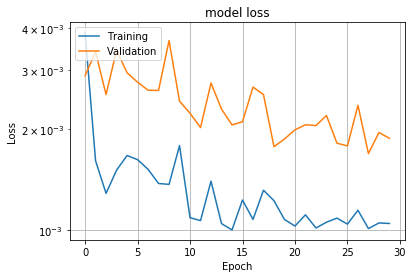

In [11]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.semilogy()
plt.show()

## Second Approach: Recurrent Model

Number of training parameters: 39921


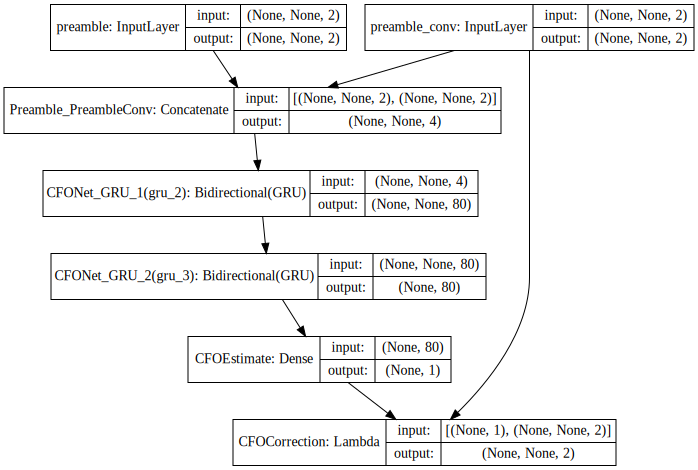

In [14]:
from tensorflow.keras.layers import Input, Bidirectional, GRU, TimeDistributed, Dense

def cfo_rnn_network(preamble, preamble_conv, scope="CFONet"):
    """
    Arguments:
        preamble :     tf.Tensor float32 -  [batch, preamble_length, 2]
        preamble_conv: tf.Tensor float32 -  [batch, preamble_length, 2]
    Return:
        cfo_est: tf.Tensor float32 - [batch_size, 1]
    """
    with tf.name_scope(scope):
        inputs = tf.keras.layers.concatenate([preamble, preamble_conv], axis=-1, 
                                             name='Preamble_PreambleConv')
        x = Bidirectional(GRU(40, 'selu', return_sequences=True), name=scope+"_GRU_1")(inputs)
        x = Bidirectional(GRU(40, 'selu', return_sequences=False),name=scope+"_GRU_2")(x)
        cfo_est = Dense(1, 'linear', name='CFOEstimate')(x)
    return cfo_est

# ############################
# Construct Recurrent Model
# ############################
preamble        = Input(shape=(None, 2), name='preamble')
preamble_conv   = Input(shape=(None, 2), name='preamble_conv')

cfo_estimate  = cfo_rnn_network(preamble, preamble_conv)
cfo_corrected_preamble = tf.keras.layers.Lambda(cfo_correction_func,
                                                name='CFOCorrection')([cfo_estimate, preamble_conv])

recurrent_model = tf.keras.Model([preamble, preamble_conv], cfo_corrected_preamble)

print("Number of training parameters: %d" % recurrent_model.count_params())
tf.keras.utils.plot_model(recurrent_model, "cfo_rnn_model.svg", show_shapes=True, show_layer_names=True)
SVG("cfo_rnn_model.svg")

## Training Recurrent model

In [15]:
recurrent_model.compile('adam','mse')

# Load a pretrained model from cheating with real omegas
recurrent_model.load_weights('../models/cfo_rnn.hdf5')  

history = recurrent_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    steps_per_epoch=1000,
    validation_steps=100,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('rnn.hdf5', save_best_only=True)],
    epochs=20, 
    workers=8)

Epoch 1/20
1000/1000 [==============================] - 214s 214ms/step - loss: 1.9164e-04 - val_loss: 1.6208e-04
Epoch 2/20
1000/1000 [==============================] - 210s 210ms/step - loss: 1.7335e-04 - val_loss: 1.7849e-04
Epoch 3/20
1000/1000 [==============================] - 208s 208ms/step - loss: 1.7796e-04 - val_loss: 1.8243e-04
Epoch 4/20
1000/1000 [==============================] - 208s 208ms/step - loss: 1.6609e-04 - val_loss: 1.7483e-04
Epoch 5/20
1000/1000 [==============================] - 213s 213ms/step - loss: 1.6384e-04 - val_loss: 1.7509e-04
Epoch 6/20
1000/1000 [==============================] - 205s 205ms/step - loss: 1.6103e-04 - val_loss: 1.5961e-04
Epoch 7/20
1000/1000 [==============================] - 202s 202ms/step - loss: 1.6102e-04 - val_loss: 1.7817e-04
Epoch 8/20
1000/1000 [==============================] - 205s 205ms/step - loss: 1.6338e-04 - val_loss: 1.6344e-04
Epoch 9/20
1000/1000 [==============================] - 215s 215ms/step - loss: 1.5647e-

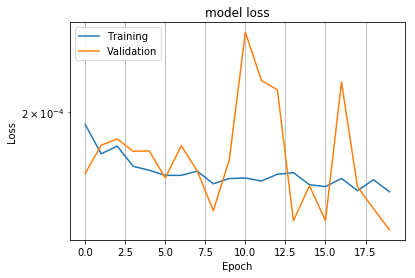

In [16]:
# Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.grid()
plt.semilogy()
plt.show()

## Evaluate models on different Omegas and SNRs

In [17]:
# Load best trained models
import tensorflow as tf

feedforward = tf.keras.models.load_model('nn.hdf5', custom_objects={"tf": tf})
recurrent_nn = tf.keras.models.load_model('rnn.hdf5',custom_objects={"tf": tf})

radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=PREAMBLE_LEN,
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')

logs = {}
for w in [1/20, 1/50, 1/100]:
    logs[w] = []
    print('[Omega]: %f' % w)
    for snr in [10.0, 15.0, 20.0, 25.0]:
        # Define testing data
        test_inputs, test_labels = next(cfo_data_genenerator(radio, w, snr, batch_size=100, seed=2020))
        
        # Make Predictions
        rnn_predictions = recurrent_nn.predict(test_inputs)
        nn_predictions  = feedforward.predict(test_inputs)
        
        # Compute MSE
        nn_mse = mean_squared_error(test_labels.flatten(), nn_predictions.flatten())
        rnn_mse =mean_squared_error(test_labels.flatten(), rnn_predictions.flatten())
        
        print('\t[SNR]: %.2f || Feedforward MSE: %.8f || RecurrentNN MSE: %.8f'% (snr, nn_mse, rnn_mse))
        logs[w].append([nn_mse, rnn_mse])

[Omega]: 0.050000
	[SNR]: 10.00 || Feedforward MSE: 0.14663590 || RecurrentNN MSE: 0.02766922
	[SNR]: 15.00 || Feedforward MSE: 0.13572569 || RecurrentNN MSE: 0.01993760
	[SNR]: 20.00 || Feedforward MSE: 0.12879810 || RecurrentNN MSE: 0.01881107
	[SNR]: 25.00 || Feedforward MSE: 0.14723061 || RecurrentNN MSE: 0.01896586
[Omega]: 0.020000
	[SNR]: 10.00 || Feedforward MSE: 0.01102252 || RecurrentNN MSE: 0.00139411
	[SNR]: 15.00 || Feedforward MSE: 0.00618016 || RecurrentNN MSE: 0.00050141
	[SNR]: 20.00 || Feedforward MSE: 0.00106193 || RecurrentNN MSE: 0.00008761
	[SNR]: 25.00 || Feedforward MSE: 0.00089930 || RecurrentNN MSE: 0.00006908
[Omega]: 0.010000
	[SNR]: 10.00 || Feedforward MSE: 0.00947697 || RecurrentNN MSE: 0.00089874
	[SNR]: 15.00 || Feedforward MSE: 0.00362929 || RecurrentNN MSE: 0.00040931
	[SNR]: 20.00 || Feedforward MSE: 0.00165418 || RecurrentNN MSE: 0.00013411
	[SNR]: 25.00 || Feedforward MSE: 0.00079488 || RecurrentNN MSE: 0.00003176


In [18]:
k= np.random.randint(0, len(test_labels) - 5)
print('K=%d'%k)
print("True CFO Rate:         ", test_labels.flatten()[k:k+6])
print("RNN Estimate CFO Rate: ", rnn_predictions.flatten()[k:k+6].T)
print("NN  Estimate CFO Rate: ", nn_predictions.flatten()[k:k+6].T)

K=17
True CFO Rate:          [ 1.022603   -0.98728664 -0.99703074 -0.99153727 -0.99028163 -0.96280783]
RNN Estimate CFO Rate:  [ 1.023672   -0.98605335 -0.99825054 -0.9901761  -0.9916427  -0.96125245]
NN  Estimate CFO Rate:  [ 1.0162373  -0.99457043 -0.989765   -0.99957204 -0.982171   -0.9719874 ]


## Evaluate on longer preamble

In [19]:
radio = RadioData(data_len    =DATA_LEN, 
                  preamble_len=2*PREAMBLE_LEN,  # 80
                  channels_len=CHANNEL_LEN,
                  modulation_scheme='QPSK')
logs = {}
for w in [1/20, 1/50, 1/100]:
    logs[w] = []
    print('[Omega]: %f' % w)
    for snr in [10.0, 15.0, 20.0, 25.0]:
        # Define testing data
        test_inputs, test_labels = next(cfo_data_genenerator(radio, w, snr, batch_size=100, seed=2020))
        
        # Make Predictions
        rnn_predictions = recurrent_nn.predict(test_inputs)
        
        # Compute MSE
        rnn_mse =mean_squared_error(test_labels.flatten(), rnn_predictions.flatten())
        
        print('\t[SNR]: %.2f  RecurrentNN MSE: %.8f'% (snr, rnn_mse))
        logs[w].append([nn_mse, rnn_mse])

[Omega]: 0.050000
	[SNR]: 10.00  RecurrentNN MSE: 0.62297205
	[SNR]: 15.00  RecurrentNN MSE: 0.65896228
	[SNR]: 20.00  RecurrentNN MSE: 0.51201780
	[SNR]: 25.00  RecurrentNN MSE: 0.57463676
[Omega]: 0.020000
	[SNR]: 10.00  RecurrentNN MSE: 0.30233274
	[SNR]: 15.00  RecurrentNN MSE: 0.33838443
	[SNR]: 20.00  RecurrentNN MSE: 0.35773075
	[SNR]: 25.00  RecurrentNN MSE: 0.37587562
[Omega]: 0.010000
	[SNR]: 10.00  RecurrentNN MSE: 0.11690618
	[SNR]: 15.00  RecurrentNN MSE: 0.14272068
	[SNR]: 20.00  RecurrentNN MSE: 0.18138774
	[SNR]: 25.00  RecurrentNN MSE: 0.13620110
